In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dpt1-dataset/DPT1.xlsx
/kaggle/input/lpt-2-dataset/LPT 2.xlsx
/kaggle/input/lpt-datasett/LPT.xlsx
/kaggle/input/lpt-1-dataset/LPT 1.xlsx


In [5]:
!pip install mpl-chord-diagram
!pip install eli5

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import eli5
from mpl_chord_diagram import chord_diagram
import re

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-04-01 08:07:38.685823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 08:07:38.685926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 08:07:38.818700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
np.random.seed(45)

In [8]:
df = pd.read_excel("/kaggle/input/lpt-datasett/LPT.xlsx")

In [9]:
df.head()

PATIENT      DOSE  LOC  MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]  \
0   PT8.nii  1.618629    2                              2858.625   
1   PT8.nii  1.630956    2                              1879.875   
2   PT8.nii  1.208252    2                              2980.125   
3  PT10.nii  5.183656    2                             22134.375   
4  PT10.nii  5.150140    2                             16632.000   

   MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]  \
0                                             3051   
1                                             2106   
2                                             3267   
3                                            22626   
4                                            16983   

   MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx]  \
0                                         113   
1                                          78   
2                                         121   
3                                         838   
4                                         629   

   MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2]  \
0                                1156.057775   
1                                1026.896014   
2                                1581.742558   
3                                6552.107722   
4                                4419.583184   

   MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]  \
0                                           0.404410   
1                                           0.546258   
2                                           0.530764   
3                                           0.296015   
4                                           0.265728   

   MORPHOLOGICAL_Compacity(IBSI:No)[]  \
0                           13.750298   
1                           17.504944   
2                           21.109076   
3                           23.960964   
4                           17.665563   

   MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]  ...  \
0                                 0.041031  ...   
1                                 0.032230  ...   
2                                 0.026727  ...   
3                                 0.023546  ...   
4                                 0.031937  ...   

   GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51)  \
0                                      299.944444   
1                                     1679.625000   
2                                      445.642857   
3                                       48.940703   
4                                       19.821869   

   GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)  \
0                                      6434.250000   
1                                      2506.500000   
2                                      3146.714286   
3                                     14586.360360   
4                                      2473.800000   

   GLSZM_GreyLevelNonUniformity(IBSI:JNSA)  \
0                                 1.000000   
1                                 1.000000   
2                                 4.142857   
3                                 8.099099   
4                                 7.371429   

   GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)  \
0                                           0.250000   
1                                           0.500000   
2                                           0.591837   
3                                           0.072965   
4                                           0.052653   

   GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)  \
0                                1.000000   
1                                1.000000   
2                                2.142857   
3                               27.648649   
4                               35.242857   

   GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)  \
0                                          0.250000   
1                                          0.500000   
2                                          0.306122   
3                                          0.2

In [10]:
df.shape

(130, 128)

In [11]:
df.dtypes

PATIENT                                              object
DOSE                                                float64
LOC                                                   int64
MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]                float64
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]       int64
                                                     ...   
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    float64
GLSZM_ZonePercentage(IBSI:P30P)                     float64
GLSZM_GreyLevelVariance(IBSI:BYLV)                  float64
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   float64
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    float64
Length: 128, dtype: object

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Columns: 128 entries, PATIENT to GLSZM_ZoneSizeEntropy(IBSI:GU8N)
dtypes: float64(111), int64(16), object(1)
memory usage: 130.1+ KB


In [13]:
df.isna().sum()

PATIENT                                             0
DOSE                                                0
LOC                                                 0
MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]                0
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]     0
                                                   ..
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    0
GLSZM_ZonePercentage(IBSI:P30P)                     0
GLSZM_GreyLevelVariance(IBSI:BYLV)                  0
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   0
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    0
Length: 128, dtype: int64

In [14]:
df.drop("PATIENT", axis = 1, inplace=True)

In [15]:
df.columns

Index(['DOSE', 'LOC', 'MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]',
       'MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]',
       'MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx]',
       'MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2]',
       'MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]',
       'MORPHOLOGICAL_Compacity(IBSI:No)[]',
       'MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       ...
       'GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'GLSZM_ZonePercentage(IBSI:P30P)', 'GLSZM_GreyLevelVariance(IBSI:BYLV)',
       'GLSZM_ZoneSizeVariance(IBSI:3NSA)',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)'],
      dtype='object', length=127)

<Axes: >

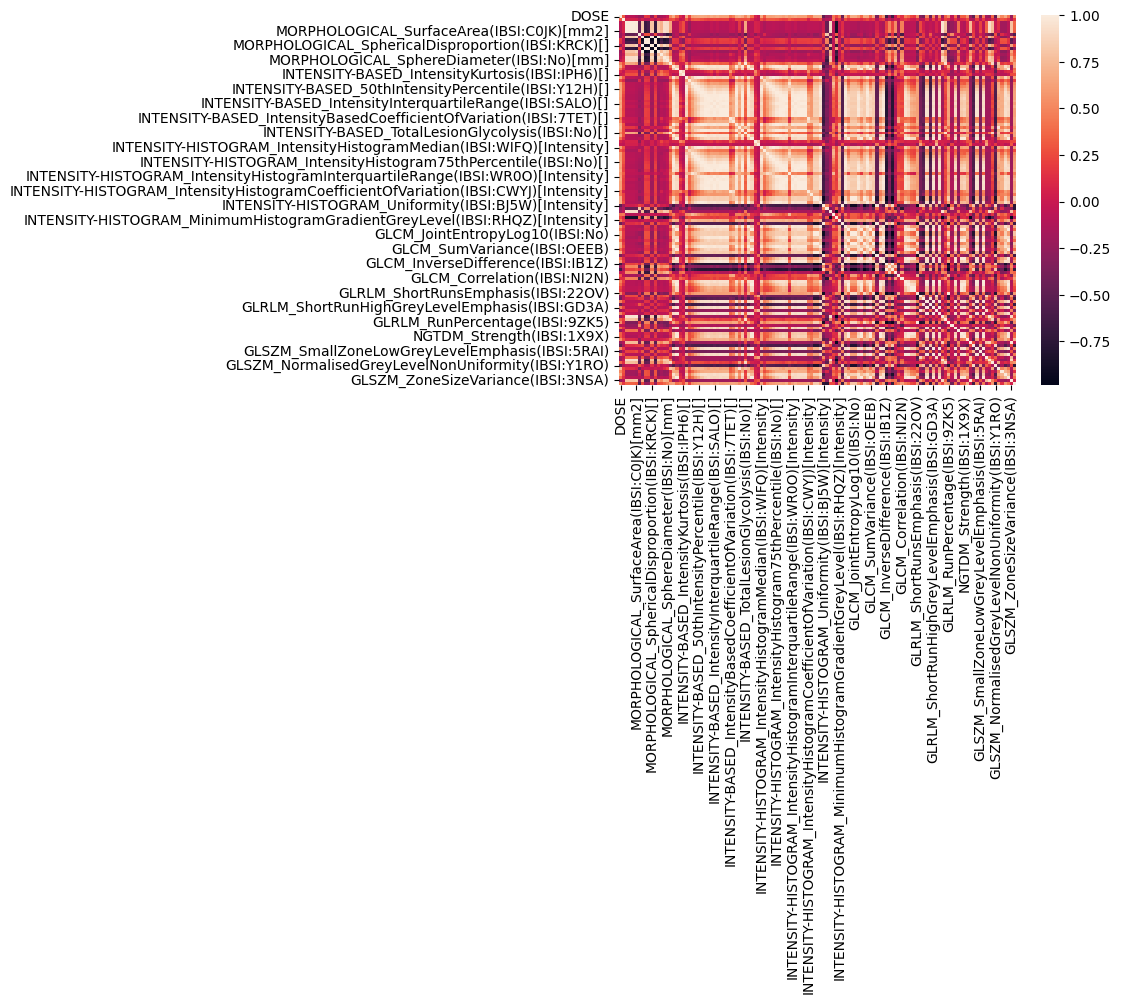

In [16]:
sns.heatmap(df.corr())

In [17]:
def calculate_scores(y, y_pred):
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    return r2, mae, mse

In [18]:
# Calculate and print mean scores for each metric
def print_scores(mode, r2_scores, mae_scores, mse_scores, rmse_scores):
    print("\nMean", mode, "Scores:")
    print("Mean R2 Score:", np.mean(r2_scores))
    print("Mean MAE:", np.mean(mae_scores))
    print("Mean MSE:", np.mean(mse_scores))
    print("Mean RMSE:", np.mean(rmse_scores))
    print()

In [19]:
# Calculate and print mean scores for each metric
def print_scores(mode, r2_scores, mae_scores, mse_scores, rmse_scores):
    print("\nMean", mode, "Scores:")
    print("Mean R2 Score:", np.mean(r2_scores))
    print("Mean MAE:", np.mean(mae_scores))
    print("Mean MSE:", np.mean(mse_scores))
    print("Mean RMSE:", np.mean(rmse_scores))
    print()

In [20]:
# This function evaluates the performance of a model over multiple iterations
# using bootstrapping and KFold cross-validation with 5 splits.

def evaluate_model(X, y, model, n_iterations=500, sample_size=0.6, print_results=True):
    r2_train_scores = []
    mae_train_scores = []
    mse_train_scores = []
    rmse_train_scores = []

    r2_test_scores = []
    mae_test_scores = []
    mse_test_scores = []
    rmse_test_scores = []
    
    # K-fold cross-validation with k = 5
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for i in range(n_iterations):
        
        # Bootstrap resampling of the data
        X_boot, y_boot = resample(X, y, replace=True, n_samples=int(sample_size * len(X)), random_state=42)
        
        r2_train_fold_scores = []
        mae_train_fold_scores = []
        mse_train_fold_scores = []
        
        r2_test_fold_scores = []
        mae_test_fold_scores = []
        mse_test_fold_scores = []
        
        for fold, (train_index, test_index) in enumerate(kf.split(X_boot), 1):
            X_train, X_test = X_boot[train_index], X_boot[test_index]
            y_train, y_test = y_boot.iloc[train_index], y_boot.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Calculate metrics
            r2_train, mae_train, mse_train = calculate_scores(y_train, y_train_pred)
            
            r2_test, mae_test, mse_test = calculate_scores(y_test, y_test_pred)
            
            # Append scores for this fold
            r2_train_fold_scores.append(r2_train)
            mae_train_fold_scores.append(mae_train)
            mse_train_fold_scores.append(mse_train)
            
            r2_test_fold_scores.append(r2_test)
            mae_test_fold_scores.append(mae_test)
            mse_test_fold_scores.append(mse_test)
            

        # Append mean scores for this iteration
        r2_train_scores.append(np.mean(r2_train_fold_scores))
        mae_train_scores.append(np.mean(mae_train_fold_scores))
        mse_train_scores.append(np.mean(mse_train_fold_scores))
        rmse_train_scores.append(np.sqrt(np.mean(mse_train_fold_scores)))
        
        r2_test_scores.append(np.mean(r2_test_fold_scores))
        mae_test_scores.append(np.mean(mae_test_fold_scores))
        mse_test_scores.append(np.mean(mse_test_fold_scores))
        rmse_test_scores.append(np.sqrt(np.mean(mse_test_fold_scores)))

    if (print_results):
        # Train scores
        print_scores('Train', r2_train_scores, mae_train_scores, mse_train_scores, rmse_train_scores)
        
        # Test scores
        print_scores('Test', r2_test_scores, mae_test_scores, mse_test_scores, rmse_test_scores)
    
    return np.mean(r2_test_scores), np.mean(mse_test_scores)

In [21]:
# This function evaluates the performance of a GradientBoostingRegressor model based on the number of selected features.
# It iterates over different numbers of selected features, starting from 8 down to 1.

def evaluate_based_on_feature_number(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Score')
    plt.title('Model Performance vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:

def evaluate_based_on_feature_number2(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    # Plot R^2 Score
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Score vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Mean Squared Error (MSE)
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
def one_hot_encoding(df, feature_name):
    if feature_name in df.columns:
        encoder = OneHotEncoder(sparse_output=False)
        encoded_data = encoder.fit_transform(df[[feature_name]])
        one_hot_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([feature_name]))
        df = pd.concat([df, one_hot_df], axis=1)
        df = df.drop(feature_name, axis=1)
    return df   

In [24]:
# For simpler visualization
def get_simple_feature_name(feature_names):
    simple_names = []
    for feature_name in feature_names:
        simple_name=feature_name
        pattern = r'\((.*)'
        match = re.search(pattern, feature_name)
        if match:
            simple_name = match.group(1)
            if simple_name in simple_names:
                last_underscore_index = feature_name.rfind('_')
                simple_name = feature_name[last_underscore_index:] if last_underscore_index != -1 else feature_name
        simple_names.append(simple_name)
    return simple_names

In [25]:
def hist_plot(df):
    df_renamed = df.copy()
    df_renamed.columns = get_simple_feature_name(df.columns)
    df_renamed.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [26]:
def pair_plot(X, y):
    X_renamed = X.copy()
    X_renamed.columns = get_simple_feature_name(X.columns)
    y_df = y.to_frame().rename(columns={0: 'Dose'})
    df = pd.concat([X_renamed, y_df], axis=1)
    for i in range(0, len(df.columns), 5):
        sns.pairplot(data=df,
                     x_vars=df.columns[i:i+5],
                     y_vars=['DOSE'])

In [27]:
def plot_chord_diagram(X):
    fig, ax = plt.subplots(figsize=(12, 12))
    chord_diagram(X.corr(), names=get_simple_feature_name(X.columns), ax=ax, rotation=0, fontsize=8)
    plt.show()

In [28]:
y=df['DOSE']
X=df.drop('DOSE', axis=1)

In [29]:
X_scaled = StandardScaler().fit_transform(X)

Section 1: Three-Step Feature Selection using Lasso Regression, Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [30]:
# Step 1: Initial feature selection using Lasso regression
# Eliminating features with lasso coef of 0
lasso = Lasso(alpha=0.01, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]
for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature LOC (0.062502)
2. Feature MORPHOLOGICAL_SphericalDisproportion(IBSI:KRCK)[] (-0.000000)
3. Feature MORPHOLOGICAL_Asphericity(IBSI:25C7)[] (-0.000000)
4. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (-0.000000)
5. Feature MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity] (-0.000000)
6. Feature INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[] (-0.000000)
7. Feature INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[] (-0.000000)
8. Feature INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[] (0.000000)
9. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[] (0.000000)
10. Feature INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[] (-0.111720)
11. Feature INTENSITY-BASED_IntensityBasedQuartileCoefficientOfDispersion(IBSI:9S40)[] (0.000000)
12. Feature INTENSITY-HISTOGRAM_IntensityHistogramSkewness(IBSI:88K1)[Intensity] (-0.005763)
13. Feature INTENSITY-HISTOGRAM_IntensityHistogramKurtosis(IBSI:C3I7)[Intensity] (-0.139138)
14. Feature INTENSITY-HISTOGRAM_IntensityHistogramMedia

In [31]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

In [32]:
X_selected = X[selected_features]

In [33]:
X_selected.columns

Index(['LOC', 'MORPHOLOGICAL_SphericalDisproportion(IBSI:KRCK)[]',
       'MORPHOLOGICAL_Asphericity(IBSI:25C7)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[]',
       'INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[]',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[]',
       'INTENSITY-BASED_IntensityBasedQuartileCoefficientOfDispersion(IBSI:9S40)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramSkewness(IBSI:88K1)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramKurtosis(IBSI:C3I7)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMedian(IBSI:WIFQ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMinimumGreyLevel(IBSI:1PR8)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram10thPercentile(IBSI:G

In [34]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

# Loop through each alpha value
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

# Plot each feature's coefficient against alpha
ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()



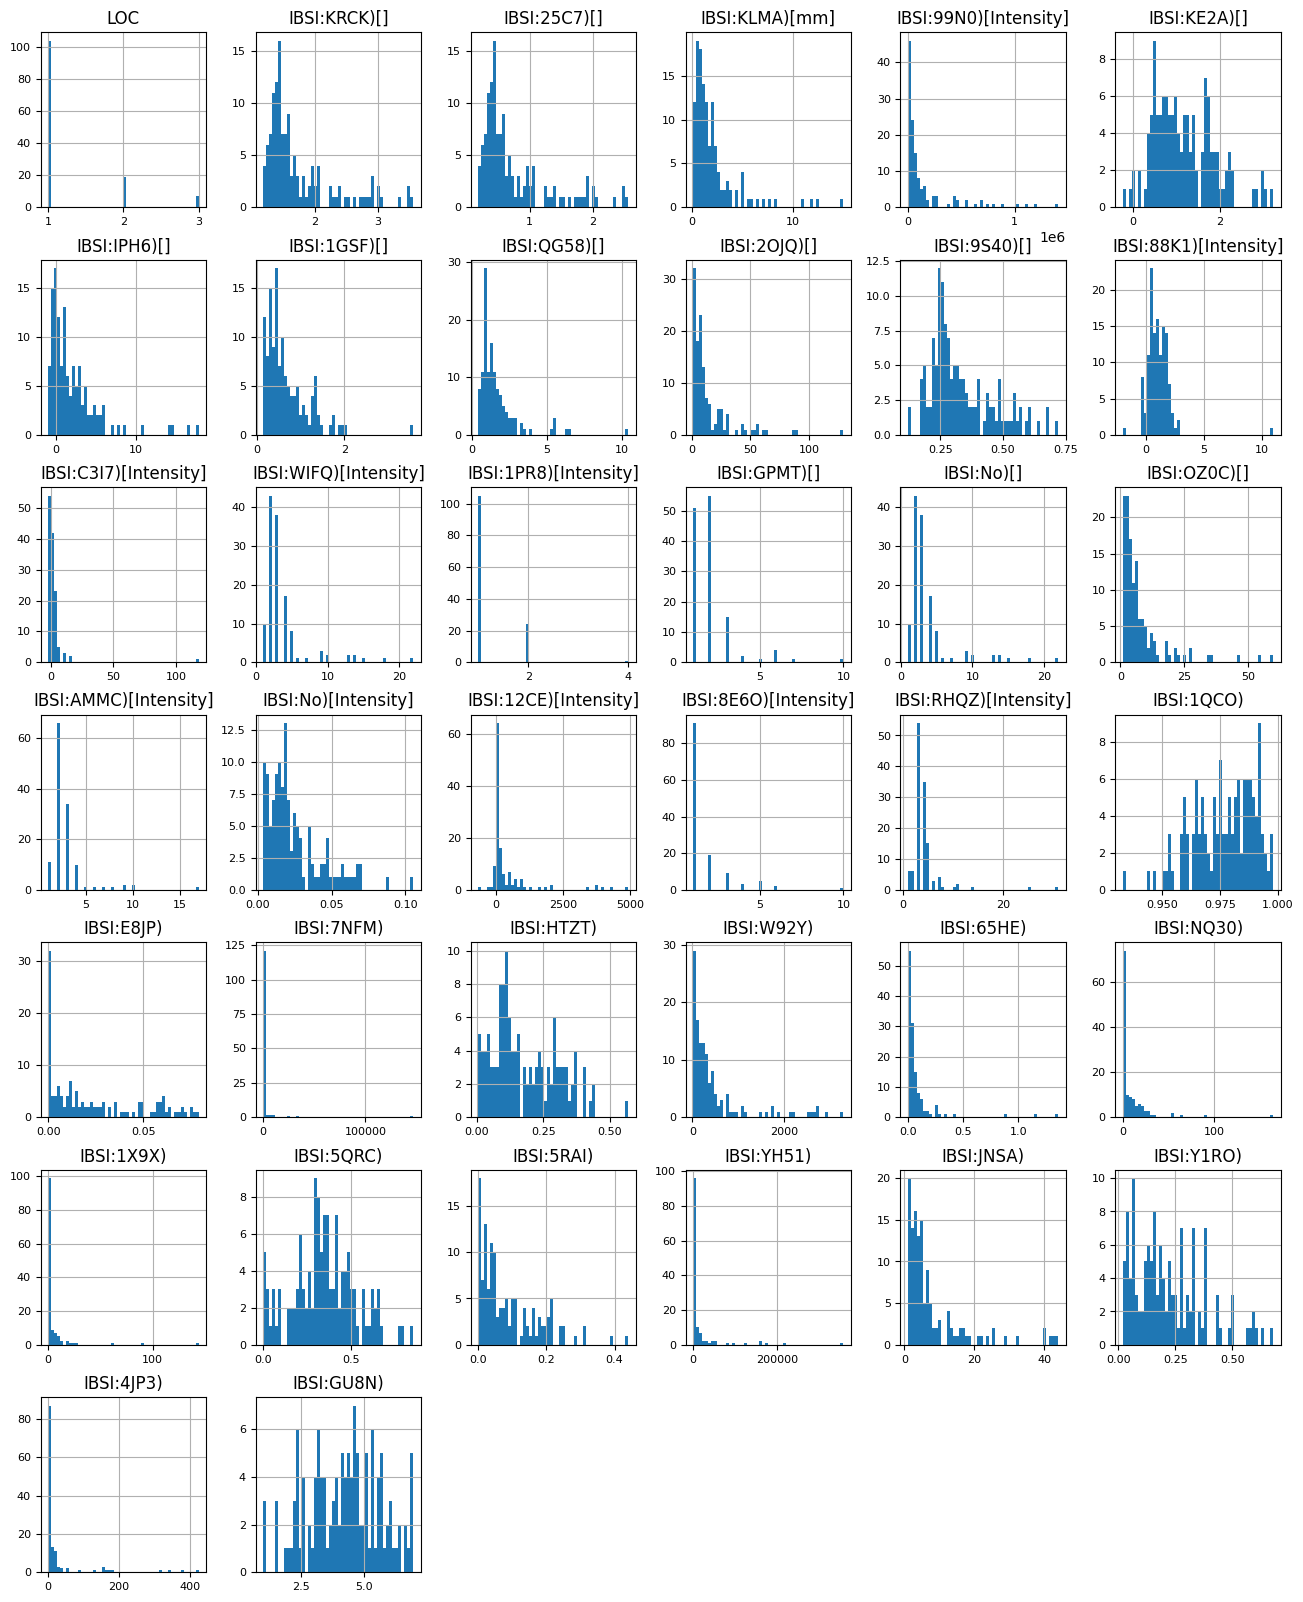

In [35]:
hist_plot(X_selected)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


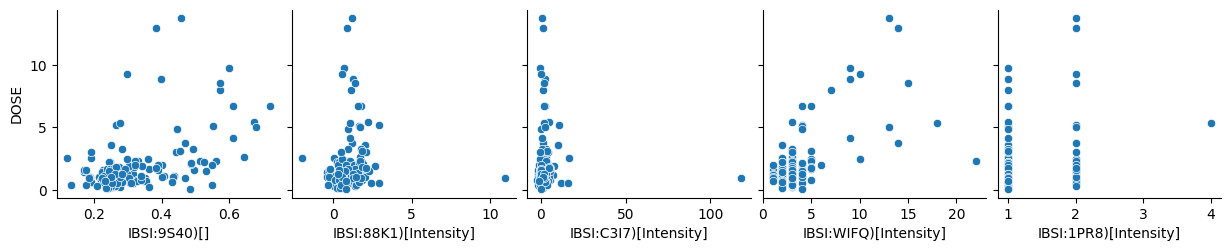

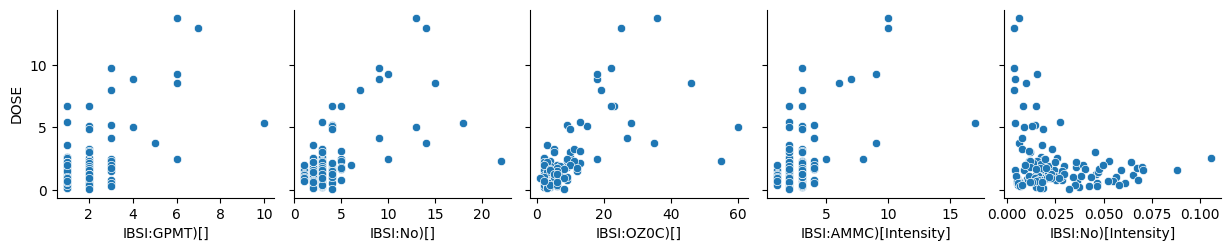

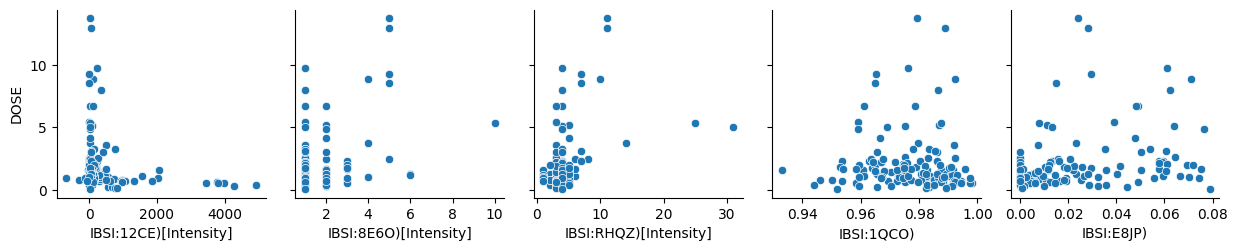

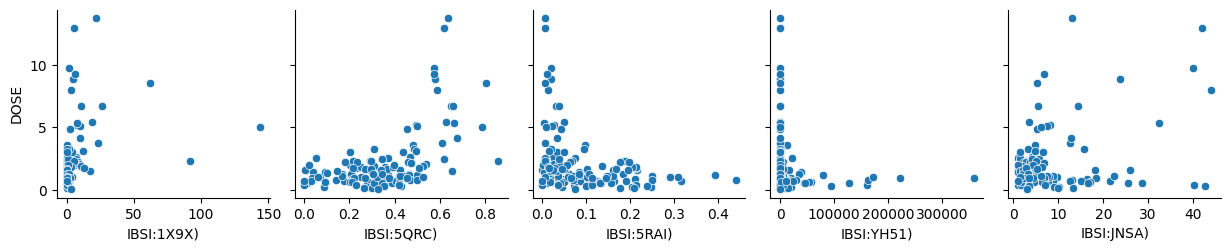

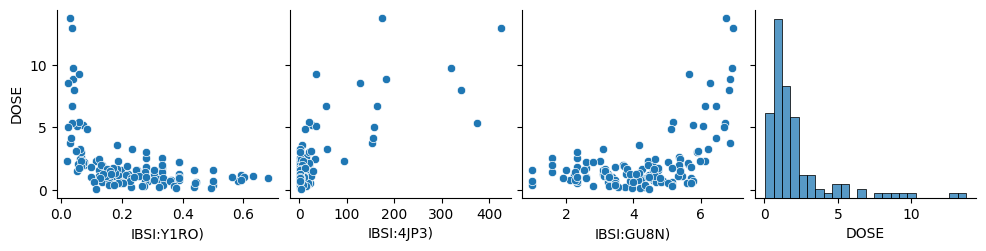

In [36]:
# Pair plots between the lasso selected features in X and the target variable DOSE.
pair_plot(X_selected, y)

In [37]:
# Encode LOC feature to one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [38]:
# Step 1 selected features
X_selected_encoded.columns

Index(['MORPHOLOGICAL_SphericalDisproportion(IBSI:KRCK)[]',
       'MORPHOLOGICAL_Asphericity(IBSI:25C7)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[]',
       'INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[]',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[]',
       'INTENSITY-BASED_IntensityBasedQuartileCoefficientOfDispersion(IBSI:9S40)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramSkewness(IBSI:88K1)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramKurtosis(IBSI:C3I7)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMedian(IBSI:WIFQ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMinimumGreyLevel(IBSI:1PR8)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram10thPercentile(IBSI:GPMT)[]'

In [39]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [40]:
# Evaluate the gradient boosting model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999219750186442
Mean MAE: 0.015273117128846192
Mean MSE: 0.0003702447284906475
Mean RMSE: 0.019241744424314745


Mean Test Scores:
Mean R2 Score: 0.775618172970607
Mean MAE: 0.5007864355311611
Mean MSE: 0.8603396961342735
Mean RMSE: 0.9275449833481253



Text(0.5, 1.0, 'Feature Importance ')

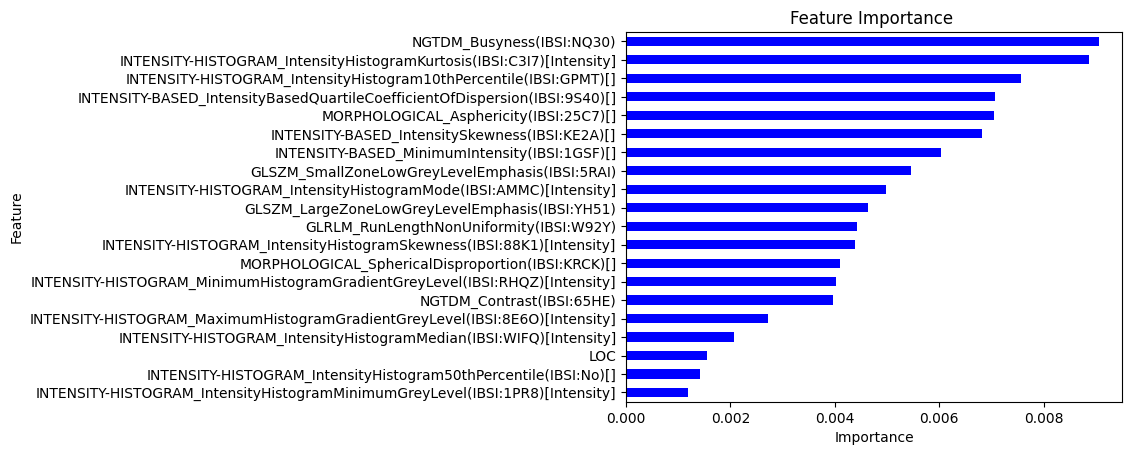

In [41]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from first step with rf feature importance > 0.01

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [42]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3) (0.250481)
2. Feature INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[] (0.190158)
3. Feature INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[] (0.124827)
4. Feature GLSZM_ZoneSizeEntropy(IBSI:GU8N) (0.080263)
5. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO) (0.054664)
6. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[] (0.029382)
7. Feature NGTDM_Strength(IBSI:1X9X) (0.021549)
8. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (0.018510)
9. Feature GLSZM_GreyLevelNonUniformity(IBSI:JNSA) (0.017160)
10. Feature MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity] (0.016751)
11. Feature GLSZM_SmallZoneEmphasis(IBSI:5QRC) (0.015984)
12. Feature GLCM_InverseVariance(IBSI:E8JP) (0.014886)
13. Feature GLCM_ClusterShade(IBSI:7NFM) (0.012799)
14. Feature INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity] (0.012606)
15. Feature INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[] (0.011273)
16. Feature 

In [43]:
X_selected2 = X_selected.iloc[:, importances>0.01]

In [44]:
# Step 2 selected features
X_selected2.columns

Index(['MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[]',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)',
       'GLCM_InverseVariance(IBSI:E8JP)', 'GLCM_ClusterShade(IBSI:7NFM)',
       'NGTDM_Strength(IBSI:1X9X)', 'GLSZM_SmallZoneEmphasis(IBSI:5QRC)',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


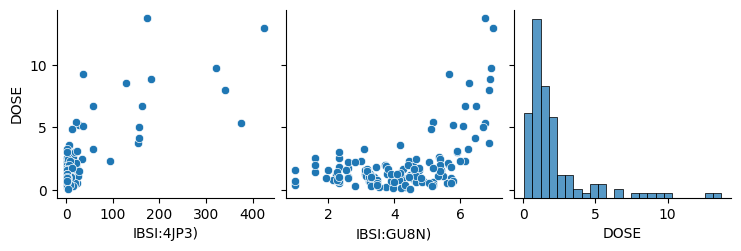

In [45]:
pair_plot(X_selected2, y)

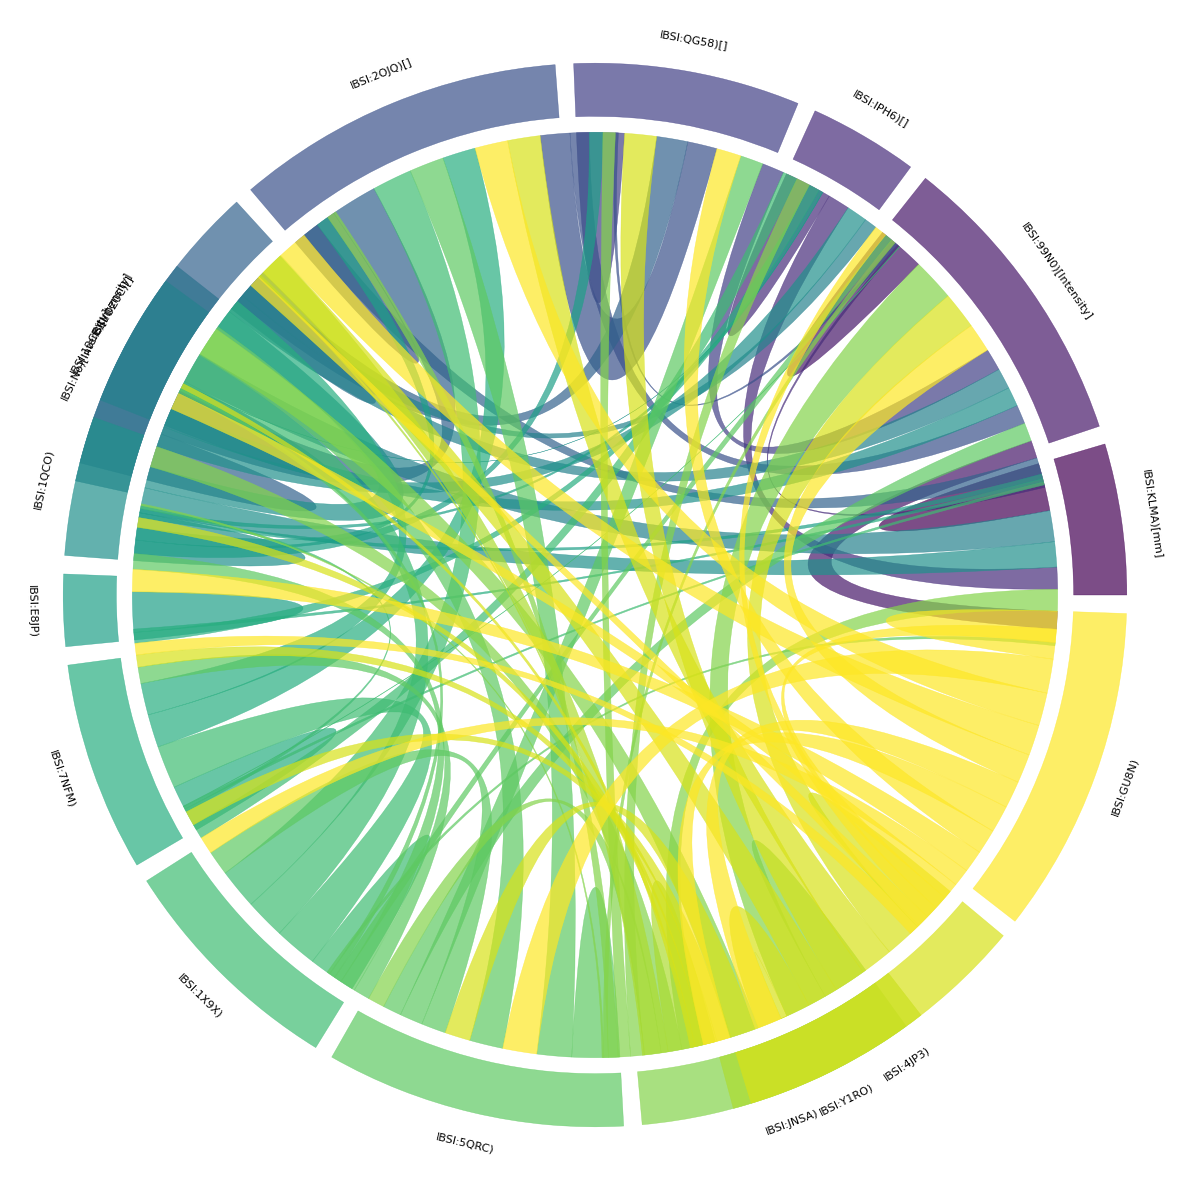

In [46]:
# Chord diagram for visualizing the correlation between selected features
plot_chord_diagram(X_selected2)

In [47]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [48]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2_encoded)

In [49]:
# Evaluate the gradient boosting model perfonmance on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9998282334418263
Mean MAE: 0.022014045929993308
Mean MSE: 0.0008072981427216028
Mean RMSE: 0.028412992498531416


Mean Test Scores:
Mean R2 Score: 0.7420392008771071
Mean MAE: 0.523877379100398
Mean MSE: 0.9217442920312653
Mean RMSE: 0.9600751491582655



In [50]:
# Step 3: Recursive Feature Elimination (RFE) Using XGBRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = XGBRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]
2. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]
3. Feature INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]
4. Feature INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]
5. Feature GLSZM_SmallZoneEmphasis(IBSI:5QRC)
6. Feature GLSZM_GreyLevelNonUniformity(IBSI:JNSA)
7. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)
8. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)


In [51]:
X_selected3 = X_selected2[selected_features]

In [52]:
X_selected3.shape

(130, 8)

In [53]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [54]:
X_selected3_sorted.shape

(130, 8)

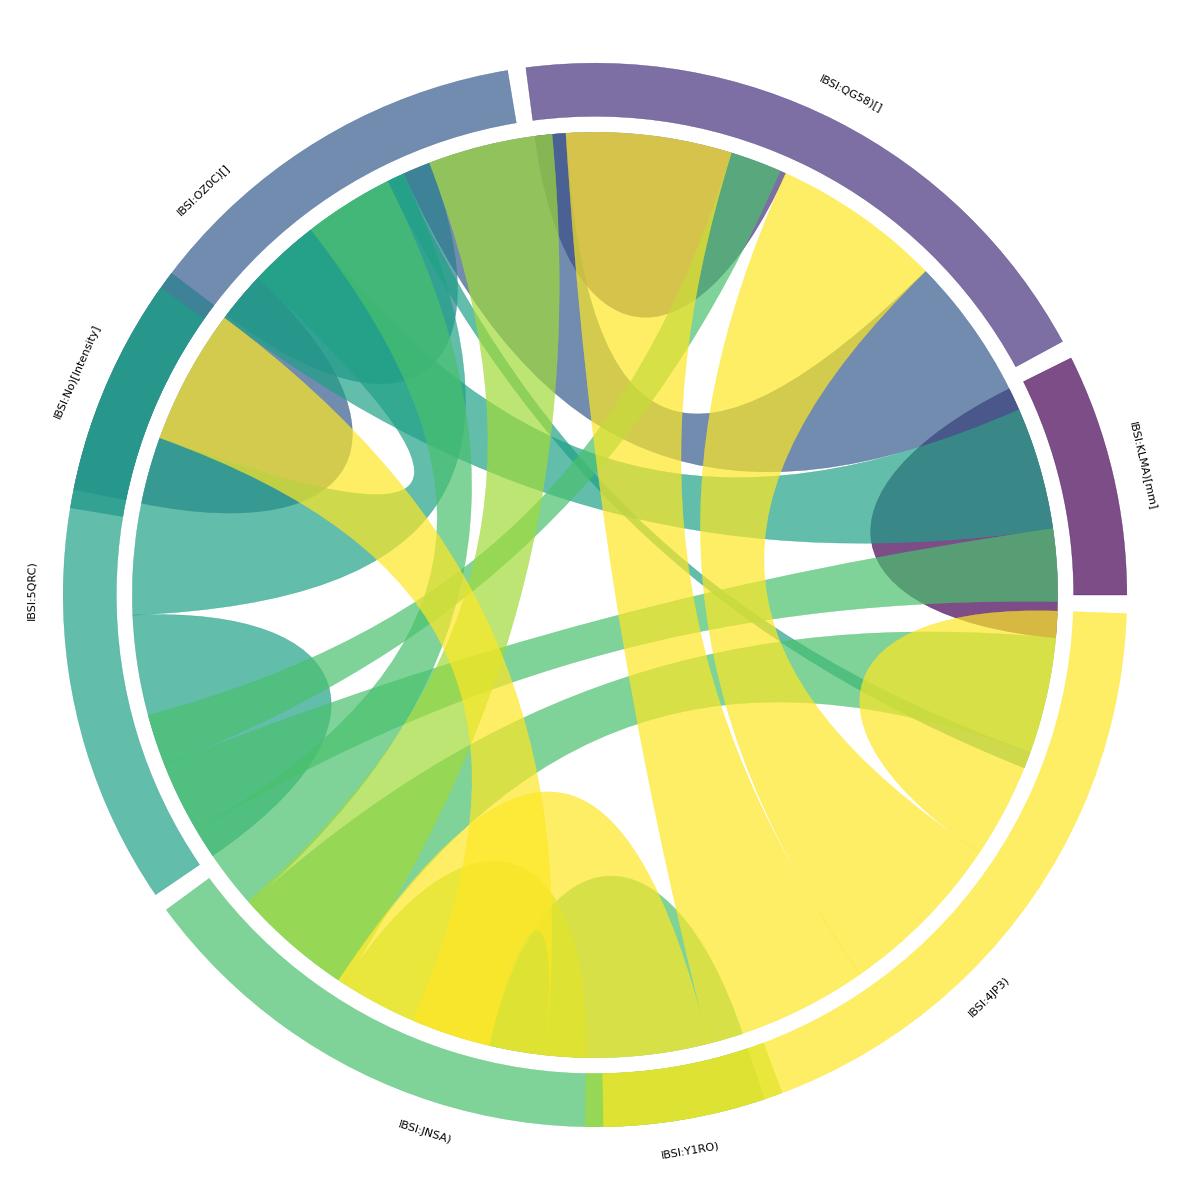

In [55]:
plot_chord_diagram(X_selected3)

In [56]:
# Final 8 selected features
X_selected3.columns

Index(['MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'GLSZM_SmallZoneEmphasis(IBSI:5QRC)',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)'],
      dtype='object')

In [57]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [58]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [59]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X_selected3, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 104, Test set:26
Fold:2, Train set: 104, Test set:26
Fold:3, Train set: 104, Test set:26
Fold:4, Train set: 104, Test set:26
Fold:5, Train set: 104, Test set:26


In [60]:
# Final evaluation after 3 step feature selection using GradientBoostingRegressor as a model
# On final 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9995140835525278
Mean MAE: 0.03502205672878987
Mean MSE: 0.0022331613498969604
Mean RMSE: 0.047256336611051004


Mean Test Scores:
Mean R2 Score: 0.7627403994282903
Mean MAE: 0.4862129800719097
Mean MSE: 0.7034929936862702
Mean RMSE: 0.8387448918987647



Section 2: One Step Feature Selection Using Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [63]:
# Recursive Feature Elimination (RFE) on the entire dataset
# Using XGBRegressor as the estimator and select 8 top features
estimator = XGBRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_scaled, y)  
selected_features = X.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))

1. Feature MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]
2. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]
3. Feature INTENSITY-BASED_IntensityBasedMeanAbsoluteDeviation(IBSI:4FUA)[]
4. Feature INTENSITY-BASED_RootMeanSquareIntensity(IBSI:5ZWQ)[]
5. Feature INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]
6. Feature INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]
7. Feature INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]
8. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)


In [64]:
X_selected = X[selected_features]

In [65]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected_sorted = X.iloc[:, sorted_selected_indices]

In [66]:
X_selected_sorted.shape

(130, 8)

In [67]:
# Correlation between selected features
plot_chord_diagram(X_selected)

In [68]:
# Evaluate the model perfonmance on 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999219750186442
Mean MAE: 0.015273117128846192
Mean MSE: 0.0003702447284906475
Mean RMSE: 0.019241744424314745


Mean Test Scores:
Mean R2 Score: 0.775618172970607
Mean MAE: 0.5007864355311611
Mean MSE: 0.8603396961342735
Mean RMSE: 0.9275449833481253



In [69]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_sorted)

Section 3: Three-Step Feature Selection using Lasso Regression (Starting from 50% feature removal), Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [72]:
# Step1: Remove 50% of features using lasso
lasso = Lasso(alpha=0.01, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]

feature_coefficients = pd.Series(lasso.coef_, index=X.columns)
sorted_coeffs = feature_coefficients.abs().sort_values(ascending=False)
num_features_to_keep = len(X.columns) // 2
selected_features = sorted_coeffs[:num_features_to_keep].index

for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity] (0.062502)
2. Feature NGTDM_Contrast(IBSI:65HE) (-0.000000)
3. Feature INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity] (-0.000000)
4. Feature INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[] (-0.000000)
5. Feature GLCM_ClusterShade(IBSI:7NFM) (-0.000000)
6. Feature INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[] (-0.000000)
7. Feature INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[] (-0.000000)
8. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3) (0.000000)
9. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[] (0.000000)
10. Feature NGTDM_Strength(IBSI:1X9X) (-0.111720)
11. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO) (0.000000)
12. Feature INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity] (-0.005763)
13. Feature INTENSITY-HISTOGRAM_IntensityHistogram50thPercentile(IBSI:No)[] (-0.139138)
14. Feature INTENSITY-HISTOGRAM_IntensityHistogram

In [73]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

In [74]:
X_selected = X[selected_features]

In [75]:
# Step 1 selected features
X_selected.columns

Index(['INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'NGTDM_Contrast(IBSI:65HE)',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]',
       'GLCM_ClusterShade(IBSI:7NFM)',
       'INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[]',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'NGTDM_Strength(IBSI:1X9X)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram50thPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram10thPercentile(IBSI:GPMT)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMedian(IBSI:WIFQ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramSkewness(IBSI:88K1)[

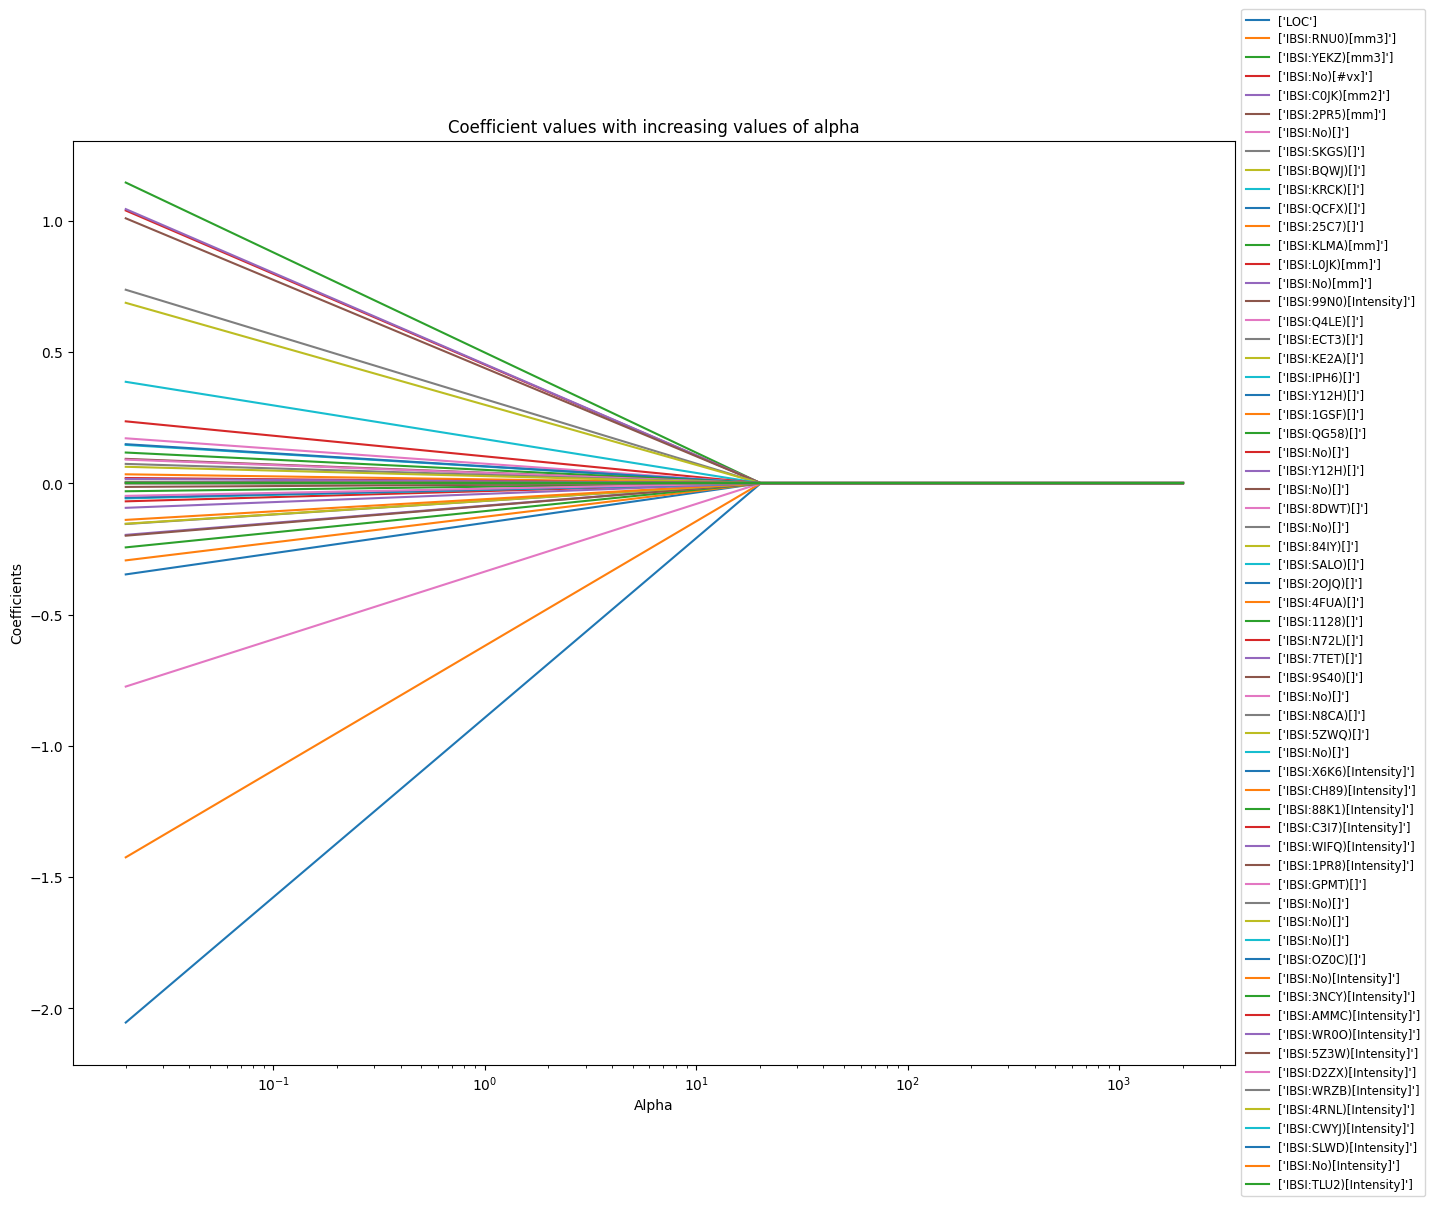

In [76]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()

In [77]:
# Encode the LOC feature using one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [78]:
X_selected_encoded.columns

Index(['INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'NGTDM_Contrast(IBSI:65HE)',
       'INTENSITY-HISTOGRAM_IntensityHistogramMode(IBSI:AMMC)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]',
       'GLCM_ClusterShade(IBSI:7NFM)',
       'INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[]',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'NGTDM_Strength(IBSI:1X9X)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'INTENSITY-HISTOGRAM_MaximumHistogramGradient(IBSI:12CE)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogram50thPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogram10thPercentile(IBSI:GPMT)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramMedian(IBSI:WIFQ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramSkewness(IBSI:88K1)[

In [79]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [80]:
# Evaluate the model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999400043104109
Mean MAE: 0.01345468478853312
Mean MSE: 0.0002766980164387831
Mean RMSE: 0.016634242286283525


Mean Test Scores:
Mean R2 Score: 0.7530796903894602
Mean MAE: 0.514999236298401
Mean MSE: 0.8153796960012544
Mean RMSE: 0.9029837739412899



In [81]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from step 1 with rf feature importance > 0.01
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

Text(0.5, 1.0, 'Feature Importance ')

In [82]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3) (0.185492)
2. Feature INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[] (0.104268)
3. Feature GLCM_SumVariance(IBSI:OEEB) (0.064598)
4. Feature GLCM_AngularSecondMoment(IBSI:8ZQL) (0.058950)
5. Feature GLSZM_ZoneSizeEntropy(IBSI:GU8N) (0.058297)
6. Feature GLCM_SumEntropy(IBSI:P6QZ) (0.044160)
7. Feature GLCM_Autocorrelation(IBSI:QWB0) (0.038016)
8. Feature GLCM_JointEntropyLog10(IBSI:No) (0.028510)
9. Feature GLCM_DifferenceEntropy(IBSI:NTRS) (0.028016)
10. Feature INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[] (0.024425)
11. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO) (0.023397)
12. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[] (0.021588)
13. Feature MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity] (0.018969)
14. Feature GLCM_ClusterTendency(IBSI:DG8W) (0.018814)
15. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (0.016593)
16. Feature INTENSITY-HISTOGRAM_IntensityHistogram10thP

In [83]:
X_selected2 = X_selected.iloc[:, importances>0.01]

In [84]:
# Step 2 selected features
X_selected2.columns

Index(['INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]',
       'INTENSITY-BASED_IntensityRange(IBSI:2OJQ)[]',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'NGTDM_Strength(IBSI:1X9X)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'INTENSITY-HISTOGRAM_IntensityHistogram10thPercentile(IBSI:GPMT)[]',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLCM_InverseVariance(IBSI:E8JP)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLCM_ClusterTendency(IBSI:DG8W)', 'GLCM_Autocorrelation(IBSI:QWB0)',
       'GLCM_JointEntropyLog10(IBSI:No)', 'GLCM_InverseDifference(IBSI:IB1Z)',
       'GLCM_AngularSecondMoment(IBSI:8ZQL)', 'GLCM_SumEntropy(IBSI:P6

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


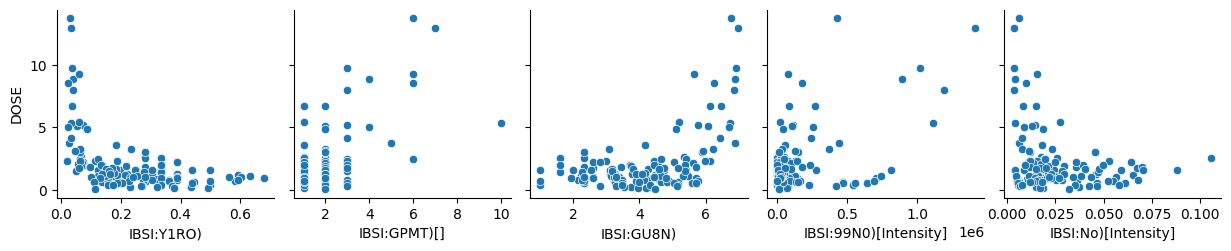

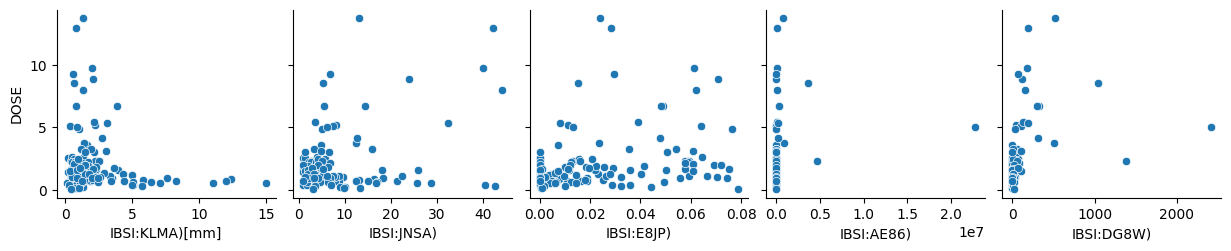

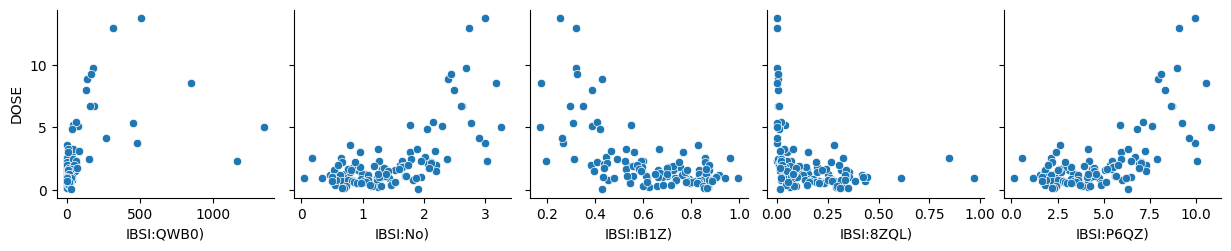

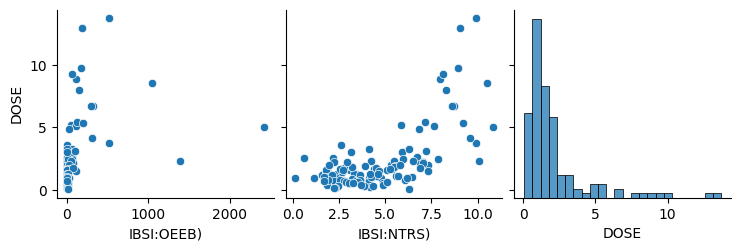

In [85]:
pair_plot(X_selected2, y)

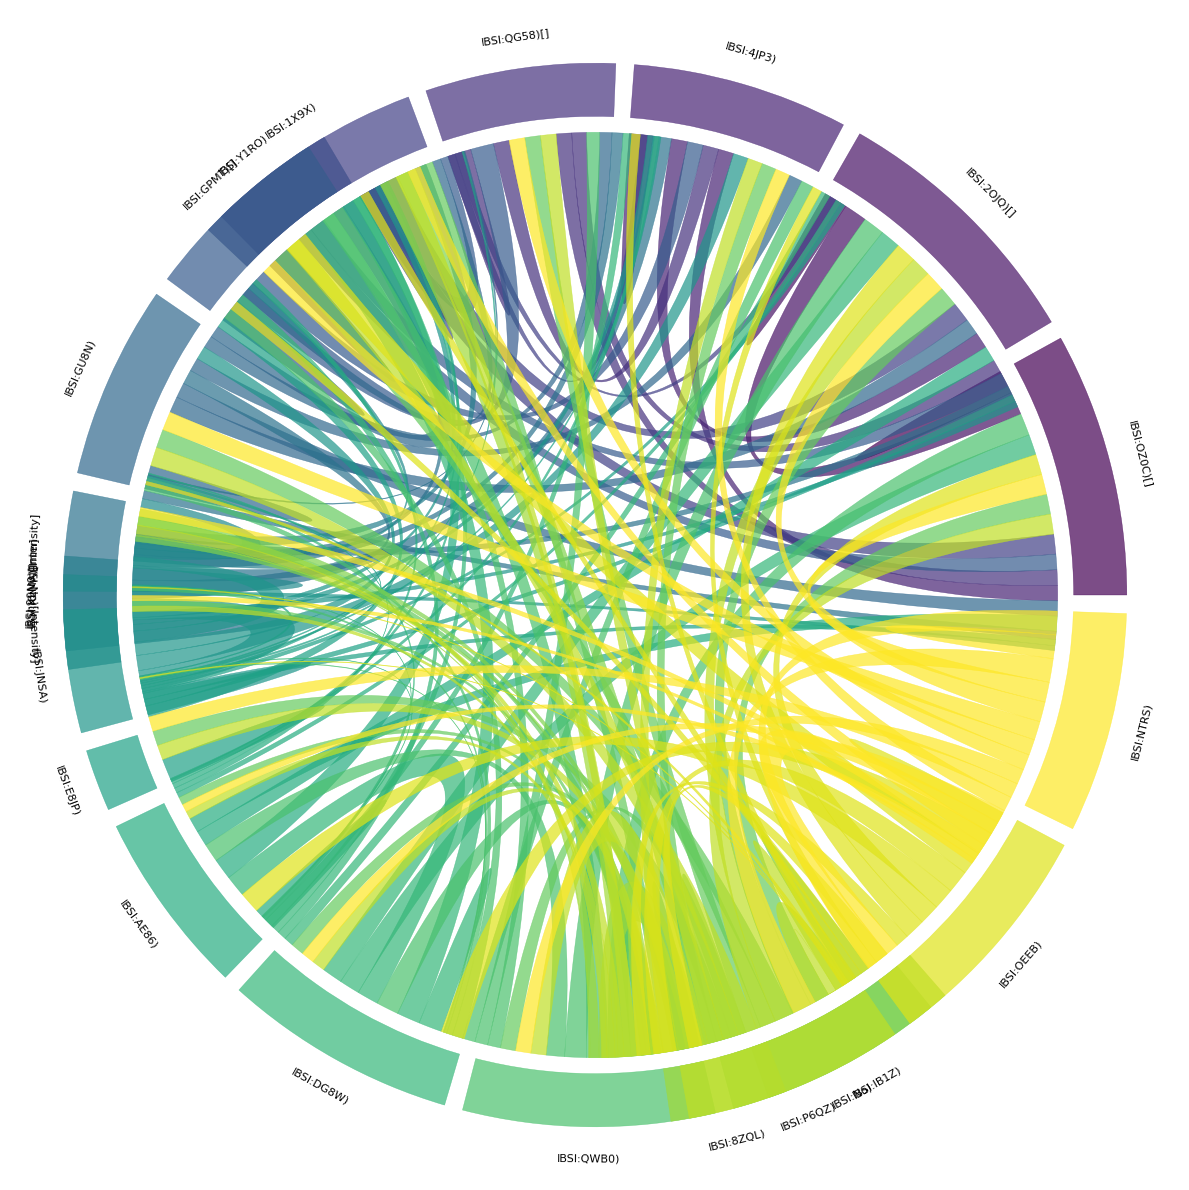

In [86]:
plot_chord_diagram(X_selected2)

In [87]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [88]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2_encoded)

In [89]:
# Evaluate model perfonmace on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9998186903276808
Mean MAE: 0.02423331156972484
Mean MSE: 0.0008544018085796015
Mean RMSE: 0.029230152387211425


Mean Test Scores:
Mean R2 Score: 0.725312977398539
Mean MAE: 0.5056059735483024
Mean MSE: 0.7498696554413476
Mean RMSE: 0.8659501460484589



In [90]:
# Step 3: Recursive Feature Elimination (RFE) Using XGBRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = XGBRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]
2. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)
3. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]
4. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)
5. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]
6. Feature GLSZM_GreyLevelNonUniformity(IBSI:JNSA)
7. Feature GLCM_Autocorrelation(IBSI:QWB0)
8. Feature GLCM_JointEntropyLog10(IBSI:No)


In [91]:
X_selected3 = X_selected2[selected_features]

In [92]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [93]:
X_selected3_sorted.shape

(130, 8)

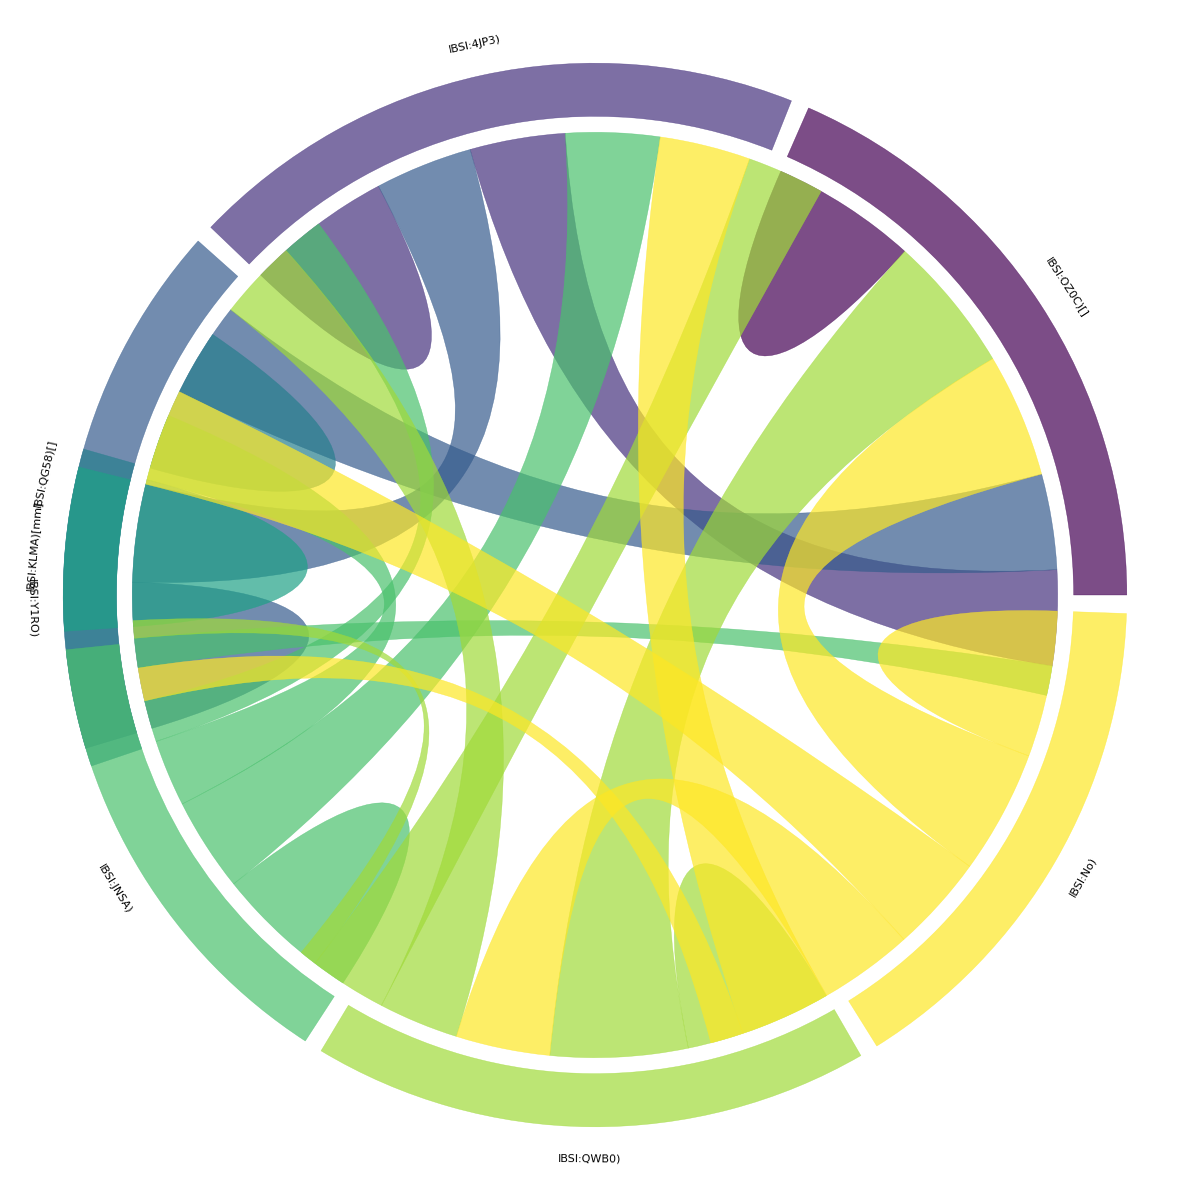

In [94]:
# Correlation plot of final selected features
plot_chord_diagram(X_selected3)

In [95]:
# Final 8 seleted features
X_selected3.columns

Index(['INTENSITY-HISTOGRAM_IntensityHistogram90thPercentile(IBSI:OZ0C)[]',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLCM_Autocorrelation(IBSI:QWB0)', 'GLCM_JointEntropyLog10(IBSI:No)'],
      dtype='object')

In [96]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [97]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [98]:
# Evaluation on 8 final selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9994417432349472
Mean MAE: 0.03999316543345211
Mean MSE: 0.002630924940019174
Mean RMSE: 0.05129254273302478


Mean Test Scores:
Mean R2 Score: 0.7784501586839473
Mean MAE: 0.49278843148120804
Mean MSE: 0.7112026329542794
Mean RMSE: 0.8433283067431566

